# <center> Estimating Patient Status Based on Laboratory Results </center>

<img src="emerg.jpg">

##      <center>      Emre Mert Dübüş - 21727192  </center>


       Today, due to epidemics and the increase in the human population, emergency services in hospitals may be insufficient. Our aim is to classify with the data set we have and determine whether the patients admitted to the hospital will be treated as outpatients or inpatients according to their laboratory results. Thus, we will prevent system crashes caused by density. 

       Technically, we'll make sure the data is well dispersed by doing K-fold cross validation and seed shuffle. Then we will try 6 different algorithms. Random Forest, Cat Boost, K-nn, K-means, SVM, Neural Network.

## Table of Content

[Problem](#problem)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling](#modeling)   
[Evaluation](#evaluation)   
[References](#references)   


## Problem <a class="anchor" id="problem"></a>

Patients who apply to the hospital are evaluated according to their urgency, especially when they enter the emergency service. Being an outpatient or an inpatient is an important classification that can save lives. In addition, you will eliminate a great burden in terms of cost. Taking the patients who can be treated as outpatients into the inpatient category will increase the density and prevent the patient who really needs to be hospitalized. Waiting or being referred will both cause medical harm and compel the person in terms of cost.

Our solution to this is; Blood is taken from patients entering the hospital, a classification can be made about the patient's condition by looking at the values in the blood taken. The dataset we have was created by a private hospital in Indonesia. That is, the data are not artificially fabricated, they are real data. There are data from 4412 different patients.

Attributes

*Blood rate
HAEMATOCRIT : Patient laboratory test result of haematocrit
HAEMOGLOBINS : Patient laboratory test result of haemoglobins
ERYTHROCYTE : Patient laboratory test result of erythrocyte
LEUCOCYTE : Patient laboratory test result of leucocyte
THROMBOCYTE : Patient laboratory test result of thrombocyte
MCH : Patient laboratory test result of MCH
MCHC : Patient laboratory test result of MCHC
MCV : Patient laboratory test result of MCV

*Person Informations
AGE : Patient age
SEX : Patient gender

*Label Information
SOURCE | Binary :  in/out 

# Required Libraries

In [1]:
import pandas as pd
import numpy as np
import copy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix

from sklearn.utils import shuffle
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

## Data Understanding<a class="anchor" id="data_understanding"></a>

In [2]:
ham_data = pd.read_csv("dscpdata.csv")

ham_data.head(5)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,F,out
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,F,out
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,F,out
3,39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1,F,out
4,30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1,M,out


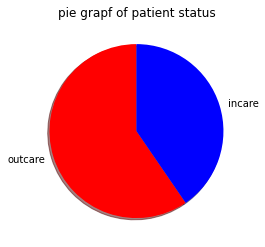

,Count of out-in care patient
out,2628
in,1784


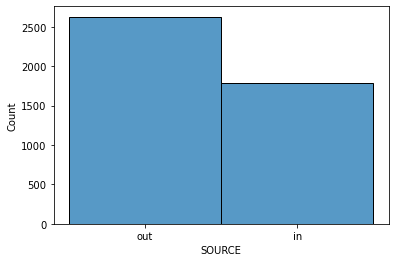

<Figure size 360x360 with 0 Axes>

In [3]:

plt.pie([2628,1784],
  labels=["outcare","incare"],
  colors=["r","b"],
  startangle=90,
  shadow= True,
  explode=(0,0))
 
plt.title('pie grapf of patient status')
plt.show()


fig = sns.histplot(x='SOURCE', data=ham_data)
plt.figure(figsize=(5,5))
ham_data.SOURCE.value_counts().to_frame(name='Count of out-in care patient')

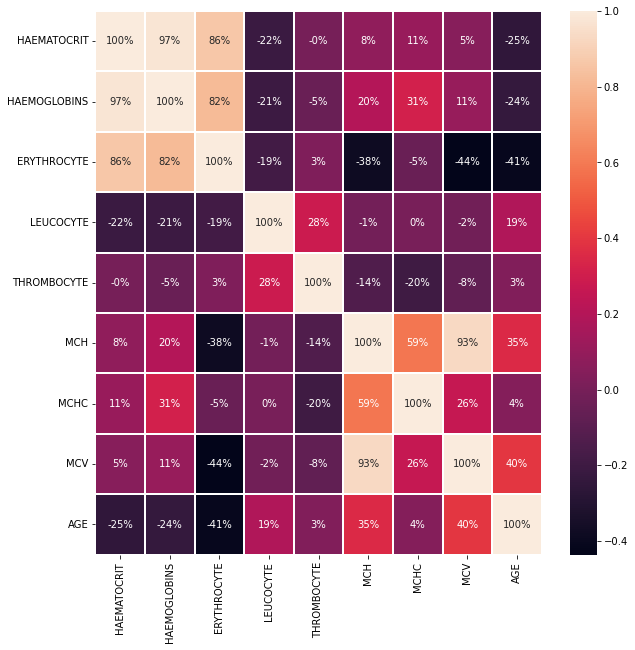

In [4]:
plt.figure(figsize=(10,10))
sns.heatmap(ham_data.corr(), annot = True, linewidths=.05, fmt='.0%')
plt.show()

We use random shuffle to distribute the data fairly, but by adjusting the seed, we ensure the same distribution in each test.

In [5]:
ham_data = shuffle(ham_data,random_state = 42)

ham_data.head(5)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
2447,45.2,15.7,5.26,11.8,343,29.8,34.7,85.9,52,M,out
2422,38.0,13.1,4.51,13.8,425,29.0,34.5,84.3,51,M,in
3973,38.9,12.8,4.28,6.3,229,29.9,32.9,90.9,75,F,out
1726,40.7,13.3,4.68,9.5,303,28.4,32.7,87.0,39,F,in
144,37.4,12.1,5.03,5.4,246,24.1,32.4,74.4,6,M,out


In [6]:
ham_data.columns

Index(['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE',
       'THROMBOCYTE', 'MCH', 'MCHC', 'MCV', 'AGE', 'SEX', 'SOURCE'],
      dtype='object')

In [7]:
ham_data.describe()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE
count,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000
mean,38.197688,12.741727,4.541260,8.718608,257.524479,28.234701,33.343042,84.612942,46.626473
std,5.974784,2.079903,0.784091,5.049041,113.972365,2.672639,1.228664,6.859101,21.731218
min,13.700000,3.800000,1.480000,1.100000,8.000000,14.900000,26.000000,54.000000,1.000000
25%,34.375000,11.400000,4.040000,5.675000,188.000000,27.200000,32.700000,81.500000,29.000000
50%,38.600000,12.900000,4.570000,7.600000,256.000000,28.700000,33.400000,85.400000,47.000000
75%,42.500000,14.200000,5.050000,10.300000,321.000000,29.800000,34.100000,88.700000,64.000000
max,69.000000,18.900000,7.860000,76.600000,1183.000000,40.800000,39.000000,115.600000,99.000000


  Here, we can see that there is *Outlier* data. 
  
There are inconsistencies between the minimum and maximum values relative to the mean.

-------------------------------------------------------------------------------------------------------------

In [8]:
ham_data.nunique().to_frame(name=" How many unique values ? ")

,How many unique values ?
HAEMATOCRIT,326
HAEMOGLOBINS,128
ERYTHROCYTE,433
LEUCOCYTE,276
THROMBOCYTE,554
MCH,189
MCHC,105
MCV,406
AGE,95
SEX,2


-------------------------------------------------------------------------------------------------------------------------------
Here we check if there is a NaN value. And we see that we have not NaN value.

In [9]:
print(ham_data.isna().values.any())

False


## Data Preparation<a class="anchor" id="data_preparation"></a>

--------------------------------------------------------
LABEL ENCODING done here.

  We convert SEX column for all datasets.        |
  M : 0  | F : 1
  
  We convert SOURCE column for all datasets.        |
  out : 0  | in : 1

In [10]:
original_dataset1 = ham_data

original_dataset1['SEX'] = original_dataset1['SEX'].map({'M': 0,'F': 1})

# ----------------------------------------------------------------------------------

original_dataset1['SOURCE'] = original_dataset1['SOURCE'].map({'out': 0,'in': 1})

original_dataset1.head(5)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
2447,45.2,15.7,5.26,11.8,343,29.8,34.7,85.9,52,0,0
2422,38.0,13.1,4.51,13.8,425,29.0,34.5,84.3,51,0,1
3973,38.9,12.8,4.28,6.3,229,29.9,32.9,90.9,75,1,0
1726,40.7,13.3,4.68,9.5,303,28.4,32.7,87.0,39,1,1
144,37.4,12.1,5.03,5.4,246,24.1,32.4,74.4,6,0,0


In [11]:
original_dataset = original_dataset1.copy(copy)

X1 = original_dataset.iloc[:,:-1]
y1 = original_dataset.iloc[:,-1]

## Modeling<a class="anchor" id="modeling"></a>

------------------------------------------------------------------------------------------------------------------------------
Parametrically, we wrote our model as a function (model_k_fold) , the first two parameters being your dataset itself and its class. The "n" parameter specifies how many folds you will validate. The dataset parameter can be your entire dataset and the model can be the algorithm you want. (should be supervised, we made unsupervised separately.)

In [12]:
def model_k_fold(x1,y1,n,dataset,model):
       
    kf = KFold(n_splits= n)
    
    accu_list = []
    
    for train_index, test_index in kf.split(dataset):
        
        x1_train, x1_test, y1_train, y1_test = x1.iloc[train_index], x1.iloc[test_index], y1.iloc[train_index], y1.iloc[test_index]

        model.fit(x1_train, y1_train)
        y_pred = model.predict(x1_test)
        
        accu_list.append(accuracy_score(y1_test, y_pred))

    result = sum(accu_list) / n
    return result

-------------------------------------------------------------------------------------------------------------------------------
As we mentioned at the beginning, we will run our model by cross validating and using 5 different supervised methods.

Support vector machines , Random forest , Cat Boost , Neural networks , K-NN algorithms have been tried separately. 
These tests were made in the form of (2 , 4 , 6 , 8 , 10 )- folds. It is aimed to find maximum accuracy by considering each k-fold value of each algorithm.

In [13]:
svm = SVC(random_state = 0)
    
rf = RandomForestClassifier(random_state=0,n_estimators=100,max_features="auto", min_samples_split=5,min_samples_leaf=1,
                                                                                              max_depth=10,bootstrap=False)
CatBoost = CatBoostClassifier(n_estimators=100, max_depth=10)
    
NN = MLPClassifier(random_state=1, max_iter=300)

knn = KNeighborsClassifier()

model_list = [svm,rf,CatBoost,NN,knn]

-------------------------------------------------------------------------------------------------------------------------------
The run function is where we set all the parameters we mentioned in the model as well.

We will work with 5 different 'k' values from 2 to 10 and 5 different methods.

In [14]:
def run_models():

    max_accu = []
    for j in model_list:
        each_accu = []
        for i in range(2,11,2):
            each_accu.append(model_k_fold(X1,y1,i,original_dataset,j))
        max_accu.append(max(each_accu))
    return max_accu

models = run_models()

Learning rate set to 0.119304
0:	learn: 0.6715170	total: 157ms	remaining: 15.6s
1:	learn: 0.6519161	total: 174ms	remaining: 8.51s
2:	learn: 0.6328952	total: 190ms	remaining: 6.15s
3:	learn: 0.6187545	total: 210ms	remaining: 5.03s
4:	learn: 0.6044843	total: 227ms	remaining: 4.32s
5:	learn: 0.5913551	total: 244ms	remaining: 3.83s
6:	learn: 0.5821647	total: 246ms	remaining: 3.26s
7:	learn: 0.5723401	total: 262ms	remaining: 3.01s
8:	learn: 0.5635507	total: 280ms	remaining: 2.83s
9:	learn: 0.5560055	total: 298ms	remaining: 2.68s
10:	learn: 0.5480567	total: 315ms	remaining: 2.55s
11:	learn: 0.5413487	total: 334ms	remaining: 2.45s
12:	learn: 0.5350797	total: 352ms	remaining: 2.35s
13:	learn: 0.5290278	total: 370ms	remaining: 2.27s
14:	learn: 0.5233254	total: 388ms	remaining: 2.2s
15:	learn: 0.5184327	total: 410ms	remaining: 2.15s
16:	learn: 0.5138218	total: 431ms	remaining: 2.1s
17:	learn: 0.5102042	total: 449ms	remaining: 2.05s
18:	learn: 0.5060004	total: 467ms	remaining: 1.99s
19:	learn: 0.

65:	learn: 0.3865383	total: 1.15s	remaining: 593ms
66:	learn: 0.3849942	total: 1.17s	remaining: 576ms
67:	learn: 0.3838499	total: 1.19s	remaining: 558ms
68:	learn: 0.3832712	total: 1.2s	remaining: 540ms
69:	learn: 0.3816899	total: 1.22s	remaining: 521ms
70:	learn: 0.3802251	total: 1.23s	remaining: 503ms
71:	learn: 0.3787293	total: 1.25s	remaining: 486ms
72:	learn: 0.3765085	total: 1.26s	remaining: 468ms
73:	learn: 0.3751754	total: 1.28s	remaining: 451ms
74:	learn: 0.3737222	total: 1.3s	remaining: 433ms
75:	learn: 0.3721772	total: 1.32s	remaining: 416ms
76:	learn: 0.3713007	total: 1.33s	remaining: 399ms
77:	learn: 0.3696593	total: 1.35s	remaining: 382ms
78:	learn: 0.3686359	total: 1.37s	remaining: 365ms
79:	learn: 0.3675043	total: 1.39s	remaining: 348ms
80:	learn: 0.3662959	total: 1.41s	remaining: 331ms
81:	learn: 0.3653888	total: 1.43s	remaining: 314ms
82:	learn: 0.3637050	total: 1.45s	remaining: 296ms
83:	learn: 0.3621816	total: 1.46s	remaining: 279ms
84:	learn: 0.3607232	total: 1.48s

36:	learn: 0.4471484	total: 686ms	remaining: 1.17s
37:	learn: 0.4460747	total: 704ms	remaining: 1.15s
38:	learn: 0.4441776	total: 723ms	remaining: 1.13s
39:	learn: 0.4424775	total: 741ms	remaining: 1.11s
40:	learn: 0.4404285	total: 760ms	remaining: 1.09s
41:	learn: 0.4382199	total: 779ms	remaining: 1.07s
42:	learn: 0.4365138	total: 797ms	remaining: 1.06s
43:	learn: 0.4343799	total: 815ms	remaining: 1.04s
44:	learn: 0.4333241	total: 834ms	remaining: 1.02s
45:	learn: 0.4313146	total: 855ms	remaining: 1s
46:	learn: 0.4292211	total: 872ms	remaining: 984ms
47:	learn: 0.4277212	total: 894ms	remaining: 968ms
48:	learn: 0.4263692	total: 912ms	remaining: 950ms
49:	learn: 0.4248376	total: 931ms	remaining: 931ms
50:	learn: 0.4234594	total: 949ms	remaining: 912ms
51:	learn: 0.4222263	total: 967ms	remaining: 892ms
52:	learn: 0.4208412	total: 985ms	remaining: 874ms
53:	learn: 0.4191684	total: 1s	remaining: 855ms
54:	learn: 0.4166237	total: 1.02s	remaining: 836ms
55:	learn: 0.4148475	total: 1.04s	rem

3:	learn: 0.6012903	total: 81ms	remaining: 1.94s
4:	learn: 0.5853210	total: 102ms	remaining: 1.94s
5:	learn: 0.5719210	total: 120ms	remaining: 1.89s
6:	learn: 0.5613117	total: 139ms	remaining: 1.85s
7:	learn: 0.5504529	total: 157ms	remaining: 1.8s
8:	learn: 0.5420365	total: 175ms	remaining: 1.77s
9:	learn: 0.5340605	total: 193ms	remaining: 1.74s
10:	learn: 0.5273201	total: 212ms	remaining: 1.71s
11:	learn: 0.5217359	total: 230ms	remaining: 1.69s
12:	learn: 0.5160111	total: 249ms	remaining: 1.66s
13:	learn: 0.5103277	total: 267ms	remaining: 1.64s
14:	learn: 0.5044122	total: 287ms	remaining: 1.63s
15:	learn: 0.4988161	total: 305ms	remaining: 1.6s
16:	learn: 0.4955181	total: 314ms	remaining: 1.53s
17:	learn: 0.4912666	total: 333ms	remaining: 1.52s
18:	learn: 0.4873224	total: 352ms	remaining: 1.5s
19:	learn: 0.4841000	total: 371ms	remaining: 1.49s
20:	learn: 0.4808279	total: 390ms	remaining: 1.47s
21:	learn: 0.4775943	total: 409ms	remaining: 1.45s
22:	learn: 0.4743811	total: 426ms	remainin

69:	learn: 0.3967947	total: 1.31s	remaining: 561ms
70:	learn: 0.3958290	total: 1.36s	remaining: 556ms
71:	learn: 0.3946685	total: 1.39s	remaining: 540ms
72:	learn: 0.3930379	total: 1.41s	remaining: 520ms
73:	learn: 0.3917704	total: 1.43s	remaining: 503ms
74:	learn: 0.3903817	total: 1.45s	remaining: 484ms
75:	learn: 0.3894633	total: 1.47s	remaining: 464ms
76:	learn: 0.3879493	total: 1.49s	remaining: 444ms
77:	learn: 0.3869039	total: 1.51s	remaining: 425ms
78:	learn: 0.3860346	total: 1.53s	remaining: 406ms
79:	learn: 0.3843757	total: 1.55s	remaining: 387ms
80:	learn: 0.3830184	total: 1.57s	remaining: 368ms
81:	learn: 0.3819728	total: 1.59s	remaining: 349ms
82:	learn: 0.3809646	total: 1.61s	remaining: 330ms
83:	learn: 0.3802015	total: 1.63s	remaining: 310ms
84:	learn: 0.3792877	total: 1.65s	remaining: 290ms
85:	learn: 0.3784242	total: 1.66s	remaining: 271ms
86:	learn: 0.3773536	total: 1.68s	remaining: 252ms
87:	learn: 0.3755897	total: 1.71s	remaining: 233ms
88:	learn: 0.3750395	total: 1.7

33:	learn: 0.4502654	total: 634ms	remaining: 1.23s
34:	learn: 0.4475068	total: 653ms	remaining: 1.21s
35:	learn: 0.4458155	total: 671ms	remaining: 1.19s
36:	learn: 0.4439436	total: 689ms	remaining: 1.17s
37:	learn: 0.4419821	total: 707ms	remaining: 1.15s
38:	learn: 0.4407974	total: 725ms	remaining: 1.13s
39:	learn: 0.4394759	total: 744ms	remaining: 1.12s
40:	learn: 0.4383994	total: 764ms	remaining: 1.1s
41:	learn: 0.4364345	total: 785ms	remaining: 1.08s
42:	learn: 0.4338899	total: 803ms	remaining: 1.06s
43:	learn: 0.4309634	total: 820ms	remaining: 1.04s
44:	learn: 0.4290781	total: 839ms	remaining: 1.02s
45:	learn: 0.4271808	total: 857ms	remaining: 1.01s
46:	learn: 0.4259155	total: 876ms	remaining: 987ms
47:	learn: 0.4238726	total: 892ms	remaining: 967ms
48:	learn: 0.4219942	total: 911ms	remaining: 948ms
49:	learn: 0.4201757	total: 929ms	remaining: 929ms
50:	learn: 0.4188438	total: 946ms	remaining: 909ms
51:	learn: 0.4173382	total: 964ms	remaining: 890ms
52:	learn: 0.4154718	total: 981m

0:	learn: 0.6619957	total: 19.4ms	remaining: 1.92s
1:	learn: 0.6365614	total: 38.4ms	remaining: 1.88s
2:	learn: 0.6149204	total: 55.9ms	remaining: 1.81s
3:	learn: 0.5973426	total: 73ms	remaining: 1.75s
4:	learn: 0.5811100	total: 91.2ms	remaining: 1.73s
5:	learn: 0.5687090	total: 109ms	remaining: 1.7s
6:	learn: 0.5582305	total: 127ms	remaining: 1.68s
7:	learn: 0.5493248	total: 145ms	remaining: 1.66s
8:	learn: 0.5409770	total: 162ms	remaining: 1.64s
9:	learn: 0.5331489	total: 179ms	remaining: 1.61s
10:	learn: 0.5257025	total: 195ms	remaining: 1.58s
11:	learn: 0.5202807	total: 214ms	remaining: 1.57s
12:	learn: 0.5147008	total: 230ms	remaining: 1.54s
13:	learn: 0.5094348	total: 247ms	remaining: 1.51s
14:	learn: 0.5045542	total: 265ms	remaining: 1.5s
15:	learn: 0.5002257	total: 282ms	remaining: 1.48s
16:	learn: 0.4965292	total: 300ms	remaining: 1.47s
17:	learn: 0.4926576	total: 318ms	remaining: 1.45s
18:	learn: 0.4894797	total: 336ms	remaining: 1.43s
19:	learn: 0.4866463	total: 355ms	remain

69:	learn: 0.3932335	total: 1.25s	remaining: 536ms
70:	learn: 0.3919241	total: 1.27s	remaining: 518ms
71:	learn: 0.3904138	total: 1.29s	remaining: 501ms
72:	learn: 0.3891283	total: 1.31s	remaining: 483ms
73:	learn: 0.3883422	total: 1.32s	remaining: 465ms
74:	learn: 0.3873935	total: 1.34s	remaining: 447ms
75:	learn: 0.3865978	total: 1.36s	remaining: 428ms
76:	learn: 0.3854067	total: 1.37s	remaining: 410ms
77:	learn: 0.3847454	total: 1.39s	remaining: 391ms
78:	learn: 0.3835589	total: 1.4s	remaining: 373ms
79:	learn: 0.3821883	total: 1.42s	remaining: 355ms
80:	learn: 0.3809534	total: 1.44s	remaining: 337ms
81:	learn: 0.3796069	total: 1.46s	remaining: 320ms
82:	learn: 0.3783969	total: 1.47s	remaining: 302ms
83:	learn: 0.3774197	total: 1.49s	remaining: 284ms
84:	learn: 0.3758955	total: 1.51s	remaining: 267ms
85:	learn: 0.3741260	total: 1.53s	remaining: 249ms
86:	learn: 0.3733820	total: 1.55s	remaining: 232ms
87:	learn: 0.3726077	total: 1.57s	remaining: 214ms
88:	learn: 0.3710603	total: 1.59

35:	learn: 0.4512872	total: 633ms	remaining: 1.13s
36:	learn: 0.4493691	total: 651ms	remaining: 1.11s
37:	learn: 0.4471741	total: 667ms	remaining: 1.09s
38:	learn: 0.4455930	total: 686ms	remaining: 1.07s
39:	learn: 0.4437604	total: 702ms	remaining: 1.05s
40:	learn: 0.4420133	total: 719ms	remaining: 1.03s
41:	learn: 0.4404717	total: 738ms	remaining: 1.02s
42:	learn: 0.4386074	total: 754ms	remaining: 1s
43:	learn: 0.4375272	total: 771ms	remaining: 981ms
44:	learn: 0.4354020	total: 787ms	remaining: 962ms
45:	learn: 0.4338509	total: 805ms	remaining: 945ms
46:	learn: 0.4329497	total: 823ms	remaining: 928ms
47:	learn: 0.4326419	total: 827ms	remaining: 896ms
48:	learn: 0.4310398	total: 846ms	remaining: 881ms
49:	learn: 0.4281740	total: 865ms	remaining: 865ms
50:	learn: 0.4260708	total: 884ms	remaining: 849ms
51:	learn: 0.4245268	total: 902ms	remaining: 833ms
52:	learn: 0.4231641	total: 920ms	remaining: 816ms
53:	learn: 0.4219505	total: 939ms	remaining: 800ms
54:	learn: 0.4202382	total: 957ms	

96:	learn: 0.3635697	total: 1.75s	remaining: 54.1ms
97:	learn: 0.3628924	total: 1.76s	remaining: 36ms
98:	learn: 0.3616233	total: 1.78s	remaining: 18ms
99:	learn: 0.3603760	total: 1.8s	remaining: 0us
Learning rate set to 0.151498
0:	learn: 0.6617077	total: 16.4ms	remaining: 1.62s
1:	learn: 0.6360617	total: 32.5ms	remaining: 1.59s
2:	learn: 0.6154495	total: 50.4ms	remaining: 1.63s
3:	learn: 0.5978697	total: 67.4ms	remaining: 1.62s
4:	learn: 0.5807064	total: 83.9ms	remaining: 1.59s
5:	learn: 0.5677891	total: 104ms	remaining: 1.62s
6:	learn: 0.5600167	total: 105ms	remaining: 1.39s
7:	learn: 0.5496577	total: 124ms	remaining: 1.43s
8:	learn: 0.5414213	total: 143ms	remaining: 1.45s
9:	learn: 0.5344723	total: 161ms	remaining: 1.45s
10:	learn: 0.5279741	total: 179ms	remaining: 1.45s
11:	learn: 0.5219133	total: 198ms	remaining: 1.45s
12:	learn: 0.5157729	total: 217ms	remaining: 1.45s
13:	learn: 0.5104033	total: 235ms	remaining: 1.44s
14:	learn: 0.5053700	total: 254ms	remaining: 1.44s
15:	learn:

60:	learn: 0.4070423	total: 1.11s	remaining: 710ms
61:	learn: 0.4053892	total: 1.13s	remaining: 691ms
62:	learn: 0.4039900	total: 1.14s	remaining: 672ms
63:	learn: 0.4010105	total: 1.16s	remaining: 655ms
64:	learn: 0.4002689	total: 1.18s	remaining: 636ms
65:	learn: 0.3985551	total: 1.2s	remaining: 618ms
66:	learn: 0.3975017	total: 1.22s	remaining: 599ms
67:	learn: 0.3956950	total: 1.24s	remaining: 582ms
68:	learn: 0.3938188	total: 1.25s	remaining: 563ms
69:	learn: 0.3921867	total: 1.27s	remaining: 545ms
70:	learn: 0.3907435	total: 1.29s	remaining: 527ms
71:	learn: 0.3893352	total: 1.31s	remaining: 510ms
72:	learn: 0.3876794	total: 1.33s	remaining: 492ms
73:	learn: 0.3868036	total: 1.35s	remaining: 473ms
74:	learn: 0.3845380	total: 1.36s	remaining: 455ms
75:	learn: 0.3834900	total: 1.38s	remaining: 437ms
76:	learn: 0.3823971	total: 1.4s	remaining: 419ms
77:	learn: 0.3808847	total: 1.42s	remaining: 401ms
78:	learn: 0.3796076	total: 1.44s	remaining: 382ms
79:	learn: 0.3781009	total: 1.46s

26:	learn: 0.4619727	total: 489ms	remaining: 1.32s
27:	learn: 0.4592249	total: 507ms	remaining: 1.3s
28:	learn: 0.4570477	total: 526ms	remaining: 1.29s
29:	learn: 0.4546769	total: 544ms	remaining: 1.27s
30:	learn: 0.4526619	total: 563ms	remaining: 1.25s
31:	learn: 0.4508169	total: 581ms	remaining: 1.23s
32:	learn: 0.4485246	total: 599ms	remaining: 1.22s
33:	learn: 0.4466478	total: 617ms	remaining: 1.2s
34:	learn: 0.4449166	total: 635ms	remaining: 1.18s
35:	learn: 0.4437334	total: 653ms	remaining: 1.16s
36:	learn: 0.4413542	total: 671ms	remaining: 1.14s
37:	learn: 0.4397763	total: 690ms	remaining: 1.13s
38:	learn: 0.4383402	total: 708ms	remaining: 1.11s
39:	learn: 0.4381509	total: 709ms	remaining: 1.06s
40:	learn: 0.4363755	total: 728ms	remaining: 1.05s
41:	learn: 0.4348629	total: 745ms	remaining: 1.03s
42:	learn: 0.4330772	total: 768ms	remaining: 1.02s
43:	learn: 0.4311730	total: 786ms	remaining: 1s
44:	learn: 0.4292364	total: 804ms	remaining: 982ms
45:	learn: 0.4282146	total: 822ms	re

97:	learn: 0.3643450	total: 1.78s	remaining: 36.3ms
98:	learn: 0.3635398	total: 1.8s	remaining: 18.2ms
99:	learn: 0.3620146	total: 1.82s	remaining: 0us
Learning rate set to 0.153327
0:	learn: 0.6610584	total: 18.4ms	remaining: 1.82s
1:	learn: 0.6356081	total: 35.8ms	remaining: 1.75s
2:	learn: 0.6147468	total: 53.3ms	remaining: 1.72s
3:	learn: 0.5973826	total: 72.7ms	remaining: 1.75s
4:	learn: 0.5814613	total: 91.1ms	remaining: 1.73s
5:	learn: 0.5686910	total: 110ms	remaining: 1.72s
6:	learn: 0.5610206	total: 111ms	remaining: 1.48s
7:	learn: 0.5506757	total: 131ms	remaining: 1.51s
8:	learn: 0.5419409	total: 151ms	remaining: 1.52s
9:	learn: 0.5345014	total: 170ms	remaining: 1.53s
10:	learn: 0.5278816	total: 187ms	remaining: 1.52s
11:	learn: 0.5211127	total: 207ms	remaining: 1.51s
12:	learn: 0.5156041	total: 226ms	remaining: 1.51s
13:	learn: 0.5104441	total: 245ms	remaining: 1.5s
14:	learn: 0.5050646	total: 263ms	remaining: 1.49s
15:	learn: 0.5004914	total: 281ms	remaining: 1.48s
16:	lear

65:	learn: 0.4004210	total: 1.2s	remaining: 617ms
66:	learn: 0.3990433	total: 1.22s	remaining: 599ms
67:	learn: 0.3974454	total: 1.23s	remaining: 581ms
68:	learn: 0.3963888	total: 1.25s	remaining: 563ms
69:	learn: 0.3946907	total: 1.27s	remaining: 545ms
70:	learn: 0.3936473	total: 1.29s	remaining: 527ms
71:	learn: 0.3925469	total: 1.31s	remaining: 509ms
72:	learn: 0.3901974	total: 1.33s	remaining: 491ms
73:	learn: 0.3886865	total: 1.34s	remaining: 472ms
74:	learn: 0.3874198	total: 1.36s	remaining: 454ms
75:	learn: 0.3854994	total: 1.38s	remaining: 436ms
76:	learn: 0.3838437	total: 1.4s	remaining: 418ms
77:	learn: 0.3824047	total: 1.42s	remaining: 400ms
78:	learn: 0.3804415	total: 1.44s	remaining: 382ms
79:	learn: 0.3794965	total: 1.46s	remaining: 364ms
80:	learn: 0.3785411	total: 1.48s	remaining: 346ms
81:	learn: 0.3774605	total: 1.5s	remaining: 328ms
82:	learn: 0.3767965	total: 1.51s	remaining: 310ms
83:	learn: 0.3756359	total: 1.53s	remaining: 292ms
84:	learn: 0.3744593	total: 1.55s	

32:	learn: 0.4524439	total: 628ms	remaining: 1.27s
33:	learn: 0.4509425	total: 647ms	remaining: 1.25s
34:	learn: 0.4491730	total: 666ms	remaining: 1.24s
35:	learn: 0.4477961	total: 688ms	remaining: 1.22s
36:	learn: 0.4459833	total: 707ms	remaining: 1.2s
37:	learn: 0.4445545	total: 727ms	remaining: 1.19s
38:	learn: 0.4421222	total: 747ms	remaining: 1.17s
39:	learn: 0.4408483	total: 765ms	remaining: 1.15s
40:	learn: 0.4396491	total: 782ms	remaining: 1.13s
41:	learn: 0.4384151	total: 800ms	remaining: 1.1s
42:	learn: 0.4373468	total: 817ms	remaining: 1.08s
43:	learn: 0.4356783	total: 834ms	remaining: 1.06s
44:	learn: 0.4347318	total: 852ms	remaining: 1.04s
45:	learn: 0.4328567	total: 868ms	remaining: 1.02s
46:	learn: 0.4312892	total: 884ms	remaining: 997ms
47:	learn: 0.4304017	total: 893ms	remaining: 968ms
48:	learn: 0.4300651	total: 895ms	remaining: 931ms
49:	learn: 0.4284805	total: 912ms	remaining: 912ms
50:	learn: 0.4269980	total: 929ms	remaining: 893ms
51:	learn: 0.4256352	total: 948ms

0:	learn: 0.6612570	total: 17.6ms	remaining: 1.75s
1:	learn: 0.6343407	total: 35.4ms	remaining: 1.73s
2:	learn: 0.6129149	total: 53.5ms	remaining: 1.73s
3:	learn: 0.5957182	total: 70.2ms	remaining: 1.68s
4:	learn: 0.5795838	total: 85.7ms	remaining: 1.63s
5:	learn: 0.5673291	total: 102ms	remaining: 1.6s
6:	learn: 0.5597594	total: 104ms	remaining: 1.38s
7:	learn: 0.5491199	total: 129ms	remaining: 1.48s
8:	learn: 0.5420934	total: 147ms	remaining: 1.49s
9:	learn: 0.5339984	total: 166ms	remaining: 1.49s
10:	learn: 0.5275623	total: 184ms	remaining: 1.49s
11:	learn: 0.5200523	total: 203ms	remaining: 1.49s
12:	learn: 0.5142130	total: 230ms	remaining: 1.54s
13:	learn: 0.5078748	total: 249ms	remaining: 1.53s
14:	learn: 0.5028822	total: 267ms	remaining: 1.51s
15:	learn: 0.4978818	total: 285ms	remaining: 1.49s
16:	learn: 0.4929660	total: 303ms	remaining: 1.48s
17:	learn: 0.4900254	total: 321ms	remaining: 1.46s
18:	learn: 0.4863433	total: 339ms	remaining: 1.44s
19:	learn: 0.4824406	total: 357ms	rem

62:	learn: 0.4022152	total: 1.12s	remaining: 659ms
63:	learn: 0.4007687	total: 1.14s	remaining: 642ms
64:	learn: 0.3989274	total: 1.16s	remaining: 625ms
65:	learn: 0.3978670	total: 1.18s	remaining: 607ms
66:	learn: 0.3965195	total: 1.2s	remaining: 590ms
67:	learn: 0.3950155	total: 1.22s	remaining: 572ms
68:	learn: 0.3935475	total: 1.23s	remaining: 554ms
69:	learn: 0.3920990	total: 1.25s	remaining: 536ms
70:	learn: 0.3901190	total: 1.27s	remaining: 518ms
71:	learn: 0.3890094	total: 1.29s	remaining: 500ms
72:	learn: 0.3877435	total: 1.3s	remaining: 481ms
73:	learn: 0.3855523	total: 1.32s	remaining: 463ms
74:	learn: 0.3835169	total: 1.34s	remaining: 446ms
75:	learn: 0.3821842	total: 1.35s	remaining: 427ms
76:	learn: 0.3807468	total: 1.37s	remaining: 409ms
77:	learn: 0.3796500	total: 1.39s	remaining: 392ms
78:	learn: 0.3786917	total: 1.41s	remaining: 374ms
79:	learn: 0.3773763	total: 1.43s	remaining: 357ms
80:	learn: 0.3761650	total: 1.45s	remaining: 339ms
81:	learn: 0.3746143	total: 1.46s

29:	learn: 0.4558199	total: 555ms	remaining: 1.29s
30:	learn: 0.4531009	total: 584ms	remaining: 1.3s
31:	learn: 0.4518468	total: 599ms	remaining: 1.27s
32:	learn: 0.4492618	total: 615ms	remaining: 1.25s
33:	learn: 0.4469592	total: 633ms	remaining: 1.23s
34:	learn: 0.4447288	total: 652ms	remaining: 1.21s
35:	learn: 0.4427906	total: 670ms	remaining: 1.19s
36:	learn: 0.4421888	total: 689ms	remaining: 1.17s
37:	learn: 0.4401220	total: 707ms	remaining: 1.15s
38:	learn: 0.4385449	total: 726ms	remaining: 1.14s
39:	learn: 0.4363970	total: 746ms	remaining: 1.12s
40:	learn: 0.4340117	total: 765ms	remaining: 1.1s
41:	learn: 0.4324398	total: 783ms	remaining: 1.08s
42:	learn: 0.4305405	total: 801ms	remaining: 1.06s
43:	learn: 0.4289342	total: 818ms	remaining: 1.04s
44:	learn: 0.4278951	total: 838ms	remaining: 1.02s
45:	learn: 0.4260290	total: 861ms	remaining: 1.01s
46:	learn: 0.4242058	total: 879ms	remaining: 991ms
47:	learn: 0.4228842	total: 897ms	remaining: 972ms
48:	learn: 0.4219396	total: 915ms

92:	learn: 0.3730135	total: 1.74s	remaining: 131ms
93:	learn: 0.3719417	total: 1.76s	remaining: 112ms
94:	learn: 0.3713249	total: 1.77s	remaining: 93.3ms
95:	learn: 0.3693931	total: 1.79s	remaining: 74.6ms
96:	learn: 0.3685726	total: 1.81s	remaining: 55.9ms
97:	learn: 0.3674415	total: 1.83s	remaining: 37.5ms
98:	learn: 0.3659573	total: 1.85s	remaining: 18.7ms
99:	learn: 0.3638492	total: 1.87s	remaining: 0us


-------------------------------------------------------------------------------------------------------------------------------
Here we see our estimation results and accuracy. (in comparison each method.)

The highest accuracy values among all k-fold values of each model were taken.

print(models)
plt.plot(["SVM","RForest","CatBoost","Neural Net.","K-NN"], models, color = 'blue')
plt.title(" Model's Max Accuracy ")
plt.xlabel('Model Names')
plt.ylabel('Maximum Accuracy')
plt.show()

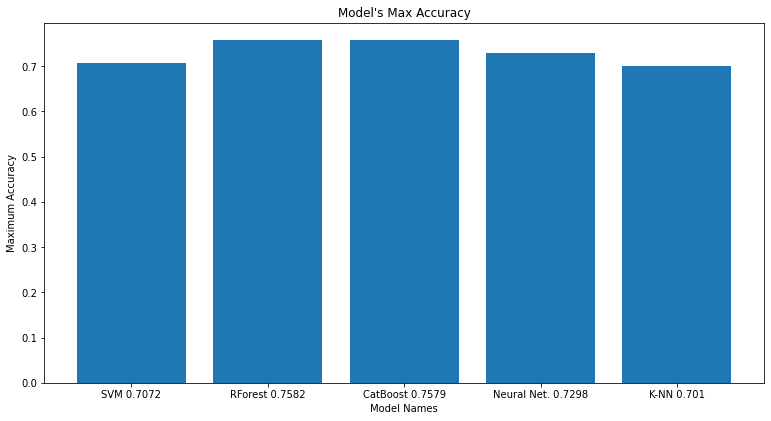

In [15]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
x = ["SVM {0}".format(models[0].round(4)),"RForest {0}".format(models[1].round(4)),"CatBoost {0}".format(models[2].round(4)),"Neural Net. {0}".format(models[3].round(4)),"K-NN {0}".format(models[4].round(4))]
y = models
ax.bar(x,y)
plt.xlabel('Model Names')
plt.ylabel('Maximum Accuracy')
plt.title("Model's Max Accuracy")
plt.show()

# Classification with Scaled Data

We had previously trained our data as is. At this stage, we will scale our data with RobustScaler, then train it and compare the results.

There are the same stages as the code, only RobustScaler() is used.

In [16]:
rf_n = RandomForestClassifier(random_state=0,n_estimators=100,max_features="auto", min_samples_split=5,min_samples_leaf=1,
                              max_depth=10,bootstrap=False)

CatBoost_n = CatBoostClassifier(n_estimators=100, max_depth=10)

model_list_n = [rf_n,CatBoost_n]

In [17]:
def model_k_fold_norm(x1,y1,n,dataset,model):
       
    kf = KFold(n_splits= n)
    scaler = RobustScaler()
    
    accu_list = []
    
    for train_index, test_index in kf.split(dataset):
        
        x1_train, x1_test, y1_train, y1_test = x1.iloc[train_index], x1.iloc[test_index], y1.iloc[train_index], y1.iloc[test_index]
        
        #   Normalization did here
        x1_train = scaler.fit_transform(x1_train)
        x1_test = scaler.transform(x1_test)
        
        
        model.fit(x1_train, y1_train)
        y_pred = model.predict(x1_test)
        
        accu_list.append(accuracy_score(y1_test, y_pred))

    result = sum(accu_list) / n
    return result

In [18]:
def run_models_normalized():

    max_accu = []
    for j in model_list_n:
        each_accu = []
        for i in range(2,11,2):
            each_accu.append(model_k_fold_norm(X1,y1,i,original_dataset,j))
        max_accu.append(max(each_accu))
    return max_accu

models_normalized = run_models_normalized()

Learning rate set to 0.119304
0:	learn: 0.6715170	total: 16.8ms	remaining: 1.66s
1:	learn: 0.6519161	total: 34.2ms	remaining: 1.68s
2:	learn: 0.6328952	total: 50.3ms	remaining: 1.63s
3:	learn: 0.6187545	total: 67.2ms	remaining: 1.61s
4:	learn: 0.6044843	total: 85.5ms	remaining: 1.62s
5:	learn: 0.5913551	total: 105ms	remaining: 1.64s
6:	learn: 0.5821647	total: 106ms	remaining: 1.4s
7:	learn: 0.5723401	total: 124ms	remaining: 1.43s
8:	learn: 0.5635507	total: 144ms	remaining: 1.46s
9:	learn: 0.5560055	total: 164ms	remaining: 1.48s
10:	learn: 0.5480567	total: 185ms	remaining: 1.5s
11:	learn: 0.5413487	total: 207ms	remaining: 1.52s
12:	learn: 0.5350797	total: 227ms	remaining: 1.52s
13:	learn: 0.5290278	total: 247ms	remaining: 1.52s
14:	learn: 0.5233254	total: 266ms	remaining: 1.51s
15:	learn: 0.5184327	total: 288ms	remaining: 1.51s
16:	learn: 0.5138218	total: 308ms	remaining: 1.5s
17:	learn: 0.5102042	total: 328ms	remaining: 1.49s
18:	learn: 0.5060004	total: 346ms	remaining: 1.48s
19:	learn

71:	learn: 0.3787293	total: 1.3s	remaining: 508ms
72:	learn: 0.3765085	total: 1.32s	remaining: 489ms
73:	learn: 0.3751754	total: 1.34s	remaining: 471ms
74:	learn: 0.3737222	total: 1.36s	remaining: 452ms
75:	learn: 0.3721772	total: 1.37s	remaining: 434ms
76:	learn: 0.3713007	total: 1.39s	remaining: 416ms
77:	learn: 0.3696593	total: 1.41s	remaining: 397ms
78:	learn: 0.3686359	total: 1.42s	remaining: 378ms
79:	learn: 0.3675043	total: 1.44s	remaining: 360ms
80:	learn: 0.3662959	total: 1.45s	remaining: 341ms
81:	learn: 0.3653888	total: 1.47s	remaining: 323ms
82:	learn: 0.3637050	total: 1.49s	remaining: 304ms
83:	learn: 0.3621816	total: 1.5s	remaining: 287ms
84:	learn: 0.3607232	total: 1.52s	remaining: 269ms
85:	learn: 0.3589143	total: 1.54s	remaining: 251ms
86:	learn: 0.3575506	total: 1.56s	remaining: 233ms
87:	learn: 0.3559849	total: 1.57s	remaining: 215ms
88:	learn: 0.3554160	total: 1.59s	remaining: 197ms
89:	learn: 0.3545086	total: 1.61s	remaining: 179ms
90:	learn: 0.3535145	total: 1.63s

37:	learn: 0.4460747	total: 733ms	remaining: 1.2s
38:	learn: 0.4441776	total: 753ms	remaining: 1.18s
39:	learn: 0.4424775	total: 774ms	remaining: 1.16s
40:	learn: 0.4404285	total: 795ms	remaining: 1.14s
41:	learn: 0.4382199	total: 814ms	remaining: 1.12s
42:	learn: 0.4365138	total: 834ms	remaining: 1.1s
43:	learn: 0.4343799	total: 856ms	remaining: 1.09s
44:	learn: 0.4333241	total: 876ms	remaining: 1.07s
45:	learn: 0.4313146	total: 896ms	remaining: 1.05s
46:	learn: 0.4292211	total: 915ms	remaining: 1.03s
47:	learn: 0.4277212	total: 935ms	remaining: 1.01s
48:	learn: 0.4263692	total: 957ms	remaining: 996ms
49:	learn: 0.4248376	total: 976ms	remaining: 976ms
50:	learn: 0.4234594	total: 993ms	remaining: 954ms
51:	learn: 0.4222263	total: 1.01s	remaining: 932ms
52:	learn: 0.4208412	total: 1.03s	remaining: 912ms
53:	learn: 0.4191684	total: 1.05s	remaining: 891ms
54:	learn: 0.4166237	total: 1.06s	remaining: 871ms
55:	learn: 0.4148475	total: 1.08s	remaining: 851ms
56:	learn: 0.4128970	total: 1.1s	

Learning rate set to 0.141855
0:	learn: 0.6646329	total: 15.9ms	remaining: 1.58s
1:	learn: 0.6407457	total: 33ms	remaining: 1.62s
2:	learn: 0.6196475	total: 48.8ms	remaining: 1.58s
3:	learn: 0.6012903	total: 67.9ms	remaining: 1.63s
4:	learn: 0.5853210	total: 86.4ms	remaining: 1.64s
5:	learn: 0.5719210	total: 108ms	remaining: 1.69s
6:	learn: 0.5613117	total: 129ms	remaining: 1.72s
7:	learn: 0.5504529	total: 153ms	remaining: 1.75s
8:	learn: 0.5420365	total: 175ms	remaining: 1.77s
9:	learn: 0.5340605	total: 198ms	remaining: 1.78s
10:	learn: 0.5273201	total: 220ms	remaining: 1.78s
11:	learn: 0.5217359	total: 238ms	remaining: 1.75s
12:	learn: 0.5160111	total: 257ms	remaining: 1.72s
13:	learn: 0.5103277	total: 285ms	remaining: 1.75s
14:	learn: 0.5044122	total: 303ms	remaining: 1.72s
15:	learn: 0.4988161	total: 322ms	remaining: 1.69s
16:	learn: 0.4955181	total: 331ms	remaining: 1.61s
17:	learn: 0.4912666	total: 349ms	remaining: 1.59s
18:	learn: 0.4873224	total: 367ms	remaining: 1.56s
19:	lear

60:	learn: 0.4106448	total: 1.2s	remaining: 765ms
61:	learn: 0.4089217	total: 1.22s	remaining: 746ms
62:	learn: 0.4075324	total: 1.23s	remaining: 725ms
63:	learn: 0.4062255	total: 1.25s	remaining: 704ms
64:	learn: 0.4044851	total: 1.27s	remaining: 683ms
65:	learn: 0.4032443	total: 1.28s	remaining: 662ms
66:	learn: 0.4016398	total: 1.3s	remaining: 641ms
67:	learn: 0.4005138	total: 1.32s	remaining: 620ms
68:	learn: 0.3992924	total: 1.33s	remaining: 600ms
69:	learn: 0.3967947	total: 1.35s	remaining: 580ms
70:	learn: 0.3958290	total: 1.37s	remaining: 560ms
71:	learn: 0.3946685	total: 1.39s	remaining: 540ms
72:	learn: 0.3930379	total: 1.41s	remaining: 520ms
73:	learn: 0.3917704	total: 1.42s	remaining: 501ms
74:	learn: 0.3903817	total: 1.44s	remaining: 481ms
75:	learn: 0.3894633	total: 1.46s	remaining: 461ms
76:	learn: 0.3879493	total: 1.48s	remaining: 442ms
77:	learn: 0.3869039	total: 1.5s	remaining: 422ms
78:	learn: 0.3860346	total: 1.51s	remaining: 402ms
79:	learn: 0.3843757	total: 1.53s	

23:	learn: 0.4726731	total: 460ms	remaining: 1.46s
24:	learn: 0.4696177	total: 482ms	remaining: 1.44s
25:	learn: 0.4670273	total: 502ms	remaining: 1.43s
26:	learn: 0.4650926	total: 520ms	remaining: 1.41s
27:	learn: 0.4627743	total: 540ms	remaining: 1.39s
28:	learn: 0.4608044	total: 558ms	remaining: 1.37s
29:	learn: 0.4581707	total: 576ms	remaining: 1.34s
30:	learn: 0.4562478	total: 594ms	remaining: 1.32s
31:	learn: 0.4544796	total: 612ms	remaining: 1.3s
32:	learn: 0.4525130	total: 630ms	remaining: 1.28s
33:	learn: 0.4502654	total: 649ms	remaining: 1.26s
34:	learn: 0.4475068	total: 669ms	remaining: 1.24s
35:	learn: 0.4458155	total: 688ms	remaining: 1.22s
36:	learn: 0.4439436	total: 706ms	remaining: 1.2s
37:	learn: 0.4419821	total: 726ms	remaining: 1.19s
38:	learn: 0.4407974	total: 747ms	remaining: 1.17s
39:	learn: 0.4394759	total: 766ms	remaining: 1.15s
40:	learn: 0.4383994	total: 783ms	remaining: 1.13s
41:	learn: 0.4364345	total: 800ms	remaining: 1.1s
42:	learn: 0.4338899	total: 818ms	

88:	learn: 0.3673152	total: 1.67s	remaining: 206ms
89:	learn: 0.3662553	total: 1.69s	remaining: 188ms
90:	learn: 0.3647944	total: 1.71s	remaining: 169ms
91:	learn: 0.3636822	total: 1.73s	remaining: 151ms
92:	learn: 0.3627155	total: 1.75s	remaining: 132ms
93:	learn: 0.3618993	total: 1.78s	remaining: 113ms
94:	learn: 0.3611856	total: 1.8s	remaining: 94.9ms
95:	learn: 0.3597212	total: 1.82s	remaining: 76ms
96:	learn: 0.3585319	total: 1.85s	remaining: 57.1ms
97:	learn: 0.3571369	total: 1.87s	remaining: 38.1ms
98:	learn: 0.3561130	total: 1.89s	remaining: 19.1ms
99:	learn: 0.3548591	total: 1.91s	remaining: 0us
Learning rate set to 0.148388
0:	learn: 0.6619957	total: 16.7ms	remaining: 1.66s
1:	learn: 0.6365614	total: 33.8ms	remaining: 1.66s
2:	learn: 0.6149204	total: 49.8ms	remaining: 1.61s
3:	learn: 0.5973426	total: 65.2ms	remaining: 1.56s
4:	learn: 0.5811100	total: 81.7ms	remaining: 1.55s
5:	learn: 0.5687090	total: 98.9ms	remaining: 1.55s
6:	learn: 0.5582305	total: 117ms	remaining: 1.56s
7:

57:	learn: 0.4103112	total: 1.08s	remaining: 784ms
58:	learn: 0.4088615	total: 1.1s	remaining: 765ms
59:	learn: 0.4079284	total: 1.12s	remaining: 744ms
60:	learn: 0.4059016	total: 1.14s	remaining: 726ms
61:	learn: 0.4045907	total: 1.15s	remaining: 706ms
62:	learn: 0.4034347	total: 1.17s	remaining: 686ms
63:	learn: 0.4023684	total: 1.18s	remaining: 666ms
64:	learn: 0.4006461	total: 1.2s	remaining: 647ms
65:	learn: 0.3992263	total: 1.22s	remaining: 627ms
66:	learn: 0.3976749	total: 1.23s	remaining: 607ms
67:	learn: 0.3965635	total: 1.25s	remaining: 588ms
68:	learn: 0.3950366	total: 1.27s	remaining: 569ms
69:	learn: 0.3932335	total: 1.29s	remaining: 552ms
70:	learn: 0.3919241	total: 1.3s	remaining: 533ms
71:	learn: 0.3904138	total: 1.32s	remaining: 514ms
72:	learn: 0.3891283	total: 1.34s	remaining: 495ms
73:	learn: 0.3883422	total: 1.35s	remaining: 476ms
74:	learn: 0.3873935	total: 1.37s	remaining: 457ms
75:	learn: 0.3865978	total: 1.39s	remaining: 439ms
76:	learn: 0.3854067	total: 1.41s	

26:	learn: 0.4687718	total: 481ms	remaining: 1.3s
27:	learn: 0.4670335	total: 500ms	remaining: 1.28s
28:	learn: 0.4646904	total: 519ms	remaining: 1.27s
29:	learn: 0.4614113	total: 537ms	remaining: 1.25s
30:	learn: 0.4592007	total: 553ms	remaining: 1.23s
31:	learn: 0.4573458	total: 572ms	remaining: 1.21s
32:	learn: 0.4569173	total: 574ms	remaining: 1.17s
33:	learn: 0.4553374	total: 594ms	remaining: 1.15s
34:	learn: 0.4538787	total: 616ms	remaining: 1.14s
35:	learn: 0.4512872	total: 637ms	remaining: 1.13s
36:	learn: 0.4493691	total: 656ms	remaining: 1.12s
37:	learn: 0.4471741	total: 674ms	remaining: 1.1s
38:	learn: 0.4455930	total: 692ms	remaining: 1.08s
39:	learn: 0.4437604	total: 710ms	remaining: 1.06s
40:	learn: 0.4420133	total: 729ms	remaining: 1.05s
41:	learn: 0.4404717	total: 748ms	remaining: 1.03s
42:	learn: 0.4386074	total: 772ms	remaining: 1.02s
43:	learn: 0.4375272	total: 790ms	remaining: 1s
44:	learn: 0.4354020	total: 809ms	remaining: 989ms
45:	learn: 0.4338509	total: 828ms	re

95:	learn: 0.3646548	total: 1.73s	remaining: 72.2ms
96:	learn: 0.3635697	total: 1.75s	remaining: 54.2ms
97:	learn: 0.3628924	total: 1.77s	remaining: 36.2ms
98:	learn: 0.3616233	total: 1.79s	remaining: 18.1ms
99:	learn: 0.3603760	total: 1.82s	remaining: 0us
Learning rate set to 0.151498
0:	learn: 0.6617077	total: 19.9ms	remaining: 1.97s
1:	learn: 0.6360617	total: 38.7ms	remaining: 1.9s
2:	learn: 0.6154495	total: 57.7ms	remaining: 1.87s
3:	learn: 0.5978697	total: 78.6ms	remaining: 1.89s
4:	learn: 0.5807064	total: 104ms	remaining: 1.98s
5:	learn: 0.5677891	total: 123ms	remaining: 1.93s
6:	learn: 0.5600167	total: 124ms	remaining: 1.65s
7:	learn: 0.5496577	total: 142ms	remaining: 1.64s
8:	learn: 0.5414213	total: 163ms	remaining: 1.65s
9:	learn: 0.5344723	total: 185ms	remaining: 1.66s
10:	learn: 0.5279741	total: 208ms	remaining: 1.68s
11:	learn: 0.5219133	total: 230ms	remaining: 1.69s
12:	learn: 0.5157729	total: 249ms	remaining: 1.67s
13:	learn: 0.5104033	total: 269ms	remaining: 1.65s
14:	le

60:	learn: 0.4070423	total: 1.22s	remaining: 782ms
61:	learn: 0.4053892	total: 1.24s	remaining: 762ms
62:	learn: 0.4039900	total: 1.27s	remaining: 746ms
63:	learn: 0.4010105	total: 1.29s	remaining: 728ms
64:	learn: 0.4002689	total: 1.32s	remaining: 709ms
65:	learn: 0.3985551	total: 1.33s	remaining: 688ms
66:	learn: 0.3975017	total: 1.35s	remaining: 667ms
67:	learn: 0.3956950	total: 1.37s	remaining: 646ms
68:	learn: 0.3938188	total: 1.39s	remaining: 623ms
69:	learn: 0.3921867	total: 1.41s	remaining: 603ms
70:	learn: 0.3907435	total: 1.43s	remaining: 582ms
71:	learn: 0.3893352	total: 1.45s	remaining: 562ms
72:	learn: 0.3876794	total: 1.46s	remaining: 541ms
73:	learn: 0.3868036	total: 1.48s	remaining: 520ms
74:	learn: 0.3845380	total: 1.5s	remaining: 500ms
75:	learn: 0.3834900	total: 1.52s	remaining: 480ms
76:	learn: 0.3823971	total: 1.53s	remaining: 459ms
77:	learn: 0.3808847	total: 1.55s	remaining: 438ms
78:	learn: 0.3796076	total: 1.57s	remaining: 418ms
79:	learn: 0.3781009	total: 1.59

26:	learn: 0.4619727	total: 503ms	remaining: 1.36s
27:	learn: 0.4592249	total: 520ms	remaining: 1.34s
28:	learn: 0.4570477	total: 537ms	remaining: 1.31s
29:	learn: 0.4546769	total: 554ms	remaining: 1.29s
30:	learn: 0.4526619	total: 570ms	remaining: 1.27s
31:	learn: 0.4508169	total: 598ms	remaining: 1.27s
32:	learn: 0.4485246	total: 615ms	remaining: 1.25s
33:	learn: 0.4466478	total: 630ms	remaining: 1.22s
34:	learn: 0.4449166	total: 646ms	remaining: 1.2s
35:	learn: 0.4437334	total: 663ms	remaining: 1.18s
36:	learn: 0.4413542	total: 680ms	remaining: 1.16s
37:	learn: 0.4397763	total: 700ms	remaining: 1.14s
38:	learn: 0.4383402	total: 721ms	remaining: 1.13s
39:	learn: 0.4381509	total: 722ms	remaining: 1.08s
40:	learn: 0.4363755	total: 742ms	remaining: 1.07s
41:	learn: 0.4348629	total: 760ms	remaining: 1.05s
42:	learn: 0.4330772	total: 780ms	remaining: 1.03s
43:	learn: 0.4311730	total: 799ms	remaining: 1.02s
44:	learn: 0.4292364	total: 829ms	remaining: 1.01s
45:	learn: 0.4282146	total: 851m

94:	learn: 0.3682705	total: 1.75s	remaining: 91.9ms
95:	learn: 0.3661711	total: 1.76s	remaining: 73.5ms
96:	learn: 0.3654469	total: 1.78s	remaining: 55.1ms
97:	learn: 0.3643450	total: 1.8s	remaining: 36.7ms
98:	learn: 0.3635398	total: 1.82s	remaining: 18.3ms
99:	learn: 0.3620146	total: 1.83s	remaining: 0us
Learning rate set to 0.153327
0:	learn: 0.6610584	total: 15.7ms	remaining: 1.55s
1:	learn: 0.6356081	total: 31.3ms	remaining: 1.53s
2:	learn: 0.6147468	total: 48.2ms	remaining: 1.56s
3:	learn: 0.5973826	total: 67.2ms	remaining: 1.61s
4:	learn: 0.5814613	total: 86.2ms	remaining: 1.64s
5:	learn: 0.5686910	total: 107ms	remaining: 1.68s
6:	learn: 0.5610206	total: 109ms	remaining: 1.45s
7:	learn: 0.5506757	total: 130ms	remaining: 1.49s
8:	learn: 0.5419409	total: 153ms	remaining: 1.54s
9:	learn: 0.5345014	total: 176ms	remaining: 1.59s
10:	learn: 0.5278816	total: 197ms	remaining: 1.6s
11:	learn: 0.5211127	total: 219ms	remaining: 1.61s
12:	learn: 0.5156041	total: 241ms	remaining: 1.61s
13:	l

56:	learn: 0.4118020	total: 1.07s	remaining: 805ms
57:	learn: 0.4108101	total: 1.08s	remaining: 786ms
58:	learn: 0.4097082	total: 1.1s	remaining: 767ms
59:	learn: 0.4085974	total: 1.12s	remaining: 748ms
60:	learn: 0.4077423	total: 1.14s	remaining: 730ms
61:	learn: 0.4062172	total: 1.16s	remaining: 711ms
62:	learn: 0.4052009	total: 1.18s	remaining: 692ms
63:	learn: 0.4032818	total: 1.2s	remaining: 673ms
64:	learn: 0.4015834	total: 1.22s	remaining: 654ms
65:	learn: 0.4004210	total: 1.23s	remaining: 636ms
66:	learn: 0.3990433	total: 1.25s	remaining: 617ms
67:	learn: 0.3974454	total: 1.27s	remaining: 599ms
68:	learn: 0.3963888	total: 1.29s	remaining: 581ms
69:	learn: 0.3946907	total: 1.31s	remaining: 563ms
70:	learn: 0.3936473	total: 1.33s	remaining: 544ms
71:	learn: 0.3925469	total: 1.35s	remaining: 525ms
72:	learn: 0.3901974	total: 1.37s	remaining: 506ms
73:	learn: 0.3886865	total: 1.39s	remaining: 487ms
74:	learn: 0.3874198	total: 1.41s	remaining: 469ms
75:	learn: 0.3854994	total: 1.43s

19:	learn: 0.4851250	total: 401ms	remaining: 1.6s
20:	learn: 0.4829231	total: 423ms	remaining: 1.59s
21:	learn: 0.4807365	total: 444ms	remaining: 1.57s
22:	learn: 0.4776566	total: 464ms	remaining: 1.55s
23:	learn: 0.4750550	total: 482ms	remaining: 1.53s
24:	learn: 0.4728694	total: 501ms	remaining: 1.5s
25:	learn: 0.4693255	total: 519ms	remaining: 1.48s
26:	learn: 0.4657330	total: 539ms	remaining: 1.46s
27:	learn: 0.4628961	total: 558ms	remaining: 1.44s
28:	learn: 0.4606799	total: 579ms	remaining: 1.42s
29:	learn: 0.4584245	total: 601ms	remaining: 1.4s
30:	learn: 0.4563275	total: 620ms	remaining: 1.38s
31:	learn: 0.4548338	total: 641ms	remaining: 1.36s
32:	learn: 0.4524439	total: 659ms	remaining: 1.34s
33:	learn: 0.4509425	total: 677ms	remaining: 1.31s
34:	learn: 0.4491730	total: 698ms	remaining: 1.3s
35:	learn: 0.4477961	total: 716ms	remaining: 1.27s
36:	learn: 0.4459833	total: 732ms	remaining: 1.25s
37:	learn: 0.4445545	total: 749ms	remaining: 1.22s
38:	learn: 0.4421222	total: 765ms	r

84:	learn: 0.3696718	total: 1.55s	remaining: 273ms
85:	learn: 0.3683454	total: 1.57s	remaining: 256ms
86:	learn: 0.3674787	total: 1.6s	remaining: 239ms
87:	learn: 0.3664403	total: 1.62s	remaining: 221ms
88:	learn: 0.3644671	total: 1.64s	remaining: 203ms
89:	learn: 0.3630109	total: 1.66s	remaining: 185ms
90:	learn: 0.3619416	total: 1.68s	remaining: 167ms
91:	learn: 0.3604978	total: 1.71s	remaining: 148ms
92:	learn: 0.3597643	total: 1.72s	remaining: 130ms
93:	learn: 0.3585604	total: 1.75s	remaining: 111ms
94:	learn: 0.3575406	total: 1.76s	remaining: 92.9ms
95:	learn: 0.3562447	total: 1.78s	remaining: 74.3ms
96:	learn: 0.3554112	total: 1.8s	remaining: 55.7ms
97:	learn: 0.3546055	total: 1.82s	remaining: 37.1ms
98:	learn: 0.3535247	total: 1.83s	remaining: 18.5ms
99:	learn: 0.3523602	total: 1.85s	remaining: 0us
Learning rate set to 0.153343
0:	learn: 0.6612570	total: 16.3ms	remaining: 1.62s
1:	learn: 0.6343407	total: 32.2ms	remaining: 1.58s
2:	learn: 0.6129149	total: 49.5ms	remaining: 1.6s
3

51:	learn: 0.4199605	total: 1.04s	remaining: 964ms
52:	learn: 0.4186610	total: 1.07s	remaining: 946ms
53:	learn: 0.4173809	total: 1.09s	remaining: 926ms
54:	learn: 0.4155364	total: 1.11s	remaining: 905ms
55:	learn: 0.4136813	total: 1.13s	remaining: 884ms
56:	learn: 0.4113770	total: 1.14s	remaining: 863ms
57:	learn: 0.4101081	total: 1.16s	remaining: 842ms
58:	learn: 0.4091721	total: 1.18s	remaining: 820ms
59:	learn: 0.4074405	total: 1.2s	remaining: 799ms
60:	learn: 0.4061178	total: 1.22s	remaining: 778ms
61:	learn: 0.4044122	total: 1.24s	remaining: 757ms
62:	learn: 0.4022152	total: 1.26s	remaining: 738ms
63:	learn: 0.4007687	total: 1.27s	remaining: 717ms
64:	learn: 0.3989274	total: 1.29s	remaining: 697ms
65:	learn: 0.3978670	total: 1.31s	remaining: 676ms
66:	learn: 0.3965195	total: 1.33s	remaining: 656ms
67:	learn: 0.3950155	total: 1.35s	remaining: 635ms
68:	learn: 0.3935475	total: 1.37s	remaining: 615ms
69:	learn: 0.3920990	total: 1.39s	remaining: 594ms
70:	learn: 0.3901190	total: 1.4s

11:	learn: 0.5180223	total: 213ms	remaining: 1.56s
12:	learn: 0.5114131	total: 232ms	remaining: 1.55s
13:	learn: 0.5059574	total: 251ms	remaining: 1.54s
14:	learn: 0.5008023	total: 270ms	remaining: 1.53s
15:	learn: 0.4955191	total: 288ms	remaining: 1.51s
16:	learn: 0.4912982	total: 306ms	remaining: 1.5s
17:	learn: 0.4874605	total: 325ms	remaining: 1.48s
18:	learn: 0.4838695	total: 343ms	remaining: 1.46s
19:	learn: 0.4806680	total: 362ms	remaining: 1.45s
20:	learn: 0.4783802	total: 381ms	remaining: 1.43s
21:	learn: 0.4754399	total: 399ms	remaining: 1.42s
22:	learn: 0.4713473	total: 420ms	remaining: 1.41s
23:	learn: 0.4683977	total: 440ms	remaining: 1.39s
24:	learn: 0.4671898	total: 441ms	remaining: 1.32s
25:	learn: 0.4654011	total: 459ms	remaining: 1.31s
26:	learn: 0.4641205	total: 478ms	remaining: 1.29s
27:	learn: 0.4621704	total: 496ms	remaining: 1.28s
28:	learn: 0.4592582	total: 515ms	remaining: 1.26s
29:	learn: 0.4558199	total: 534ms	remaining: 1.25s
30:	learn: 0.4531009	total: 552m

74:	learn: 0.3938259	total: 1.43s	remaining: 478ms
75:	learn: 0.3922502	total: 1.46s	remaining: 461ms
76:	learn: 0.3911605	total: 1.49s	remaining: 445ms
77:	learn: 0.3895632	total: 1.52s	remaining: 428ms
78:	learn: 0.3887036	total: 1.54s	remaining: 410ms
79:	learn: 0.3876178	total: 1.57s	remaining: 392ms
80:	learn: 0.3867549	total: 1.59s	remaining: 374ms
81:	learn: 0.3860998	total: 1.61s	remaining: 355ms
82:	learn: 0.3838726	total: 1.64s	remaining: 336ms
83:	learn: 0.3830531	total: 1.67s	remaining: 318ms
84:	learn: 0.3818142	total: 1.7s	remaining: 299ms
85:	learn: 0.3804180	total: 1.72s	remaining: 280ms
86:	learn: 0.3786096	total: 1.74s	remaining: 260ms
87:	learn: 0.3779289	total: 1.77s	remaining: 241ms
88:	learn: 0.3760994	total: 1.8s	remaining: 222ms
89:	learn: 0.3757866	total: 1.82s	remaining: 203ms
90:	learn: 0.3749613	total: 1.85s	remaining: 183ms
91:	learn: 0.3741887	total: 1.88s	remaining: 163ms
92:	learn: 0.3730135	total: 1.91s	remaining: 143ms
93:	learn: 0.3719417	total: 1.93s

[0.758838920183458, 0.7579329102447869]


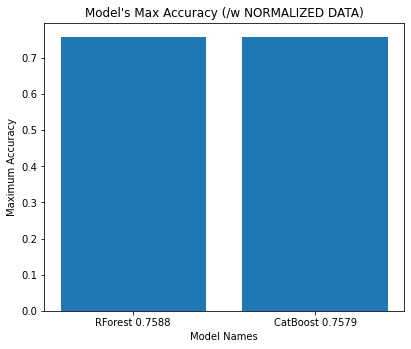

In [19]:
print(models_normalized)
fig = plt.figure(figsize=(5,4))
ax = fig.add_axes([0,0,1,1])
x = ["RForest {0}".format(models_normalized[0].round(4)),"CatBoost {0}".format(models_normalized[1].round(4))]
y = models_normalized
ax.bar(x,y)
plt.xlabel('Model Names')
plt.ylabel('Maximum Accuracy')
plt.title("Model's Max Accuracy (/w NORMALIZED DATA)")
plt.show()

# with K-Means Clustering

In [23]:
KMeans_Clustering = KMeans(n_clusters =2, random_state=0)
KMeans_Clustering.fit(X1.iloc[:,:-1])

#prediction using kmeans and accuracy

kpred = KMeans_Clustering.predict(X1.iloc[:,:-1])

print('Classification report:\n\n', classification_report(y1,kpred))

Classification report:

               precision    recall  f1-score   support

           0       0.51      0.46      0.48      2628
           1       0.30      0.35      0.33      1784

    accuracy                           0.41      4412
   macro avg       0.41      0.40      0.40      4412
weighted avg       0.43      0.41      0.42      4412



We applied the K-means clustering technique. We were not surprised to find low accuracy . We expected it to be lower than the supervised methods we already had.

## Evaluation<a class="anchor" id="evaluation"></a>

Here, we have visualized the 10-fold CV, which gives the highest accuracy rate, in order to more easily examine the random forest, which we see giving the highest result. We used heatmap, confusion matrix and classic bar graphics while making the visualization.

In [21]:
def visualize(x1,y1,n,dataset,model):
       
    kf = KFold(n_splits= n)
    scaler = RobustScaler()
    
    accu_list = []
    
    for train_index, test_index in kf.split(dataset):
        
        x1_train, x1_test, y1_train, y1_test = x1.iloc[train_index], x1.iloc[test_index], y1.iloc[train_index], y1.iloc[test_index]
        
        #   Normalization did here
        x1_train = scaler.fit_transform(x1_train)
        x1_test = scaler.transform(x1_test)
                
        model.fit(x1_train, y1_train)
        y_pred = model.predict(x1_test)
        
        
        confusion_matrix_graph = sns.heatmap(confusion_matrix(y_pred, y1_test), annot=True, fmt="d", cmap="coolwarm", xticklabels=["out care", "in care"], yticklabels=["out care","in care"])
        plt.title("Confusion Matrix for 10-fold Random Forest (Best Accuracy) \n Accuracy {0} ".format(accuracy_score(y1_test, y_pred).round(4)))
        plt.xlabel("Actual values")
        plt.ylabel("Predicted values")
        plt.show()
        accu_list.append(accuracy_score(y1_test, y_pred))

    return accu_list

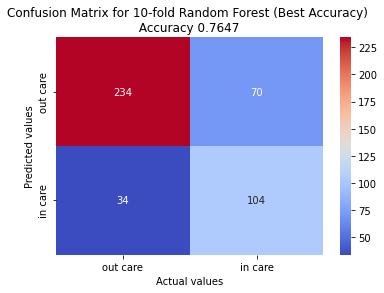

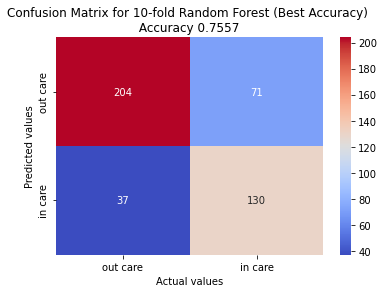

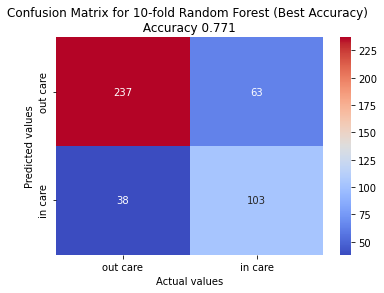

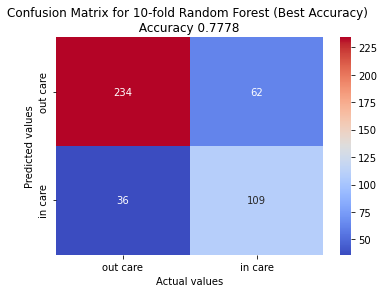

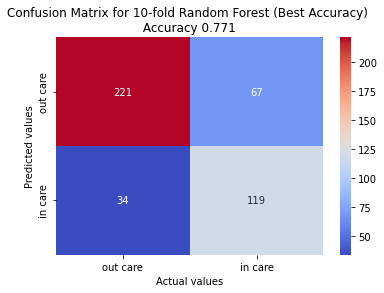

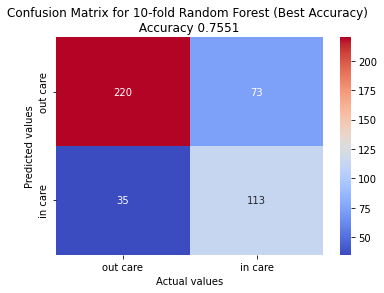

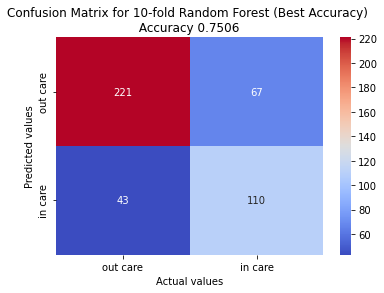

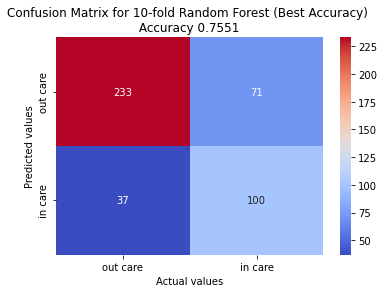

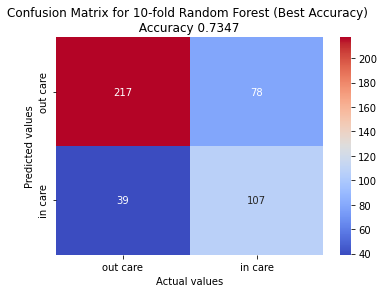

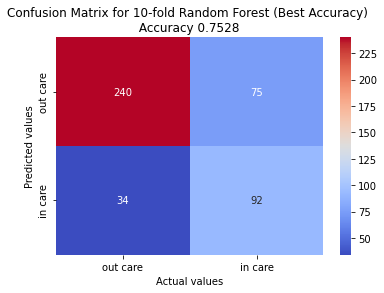

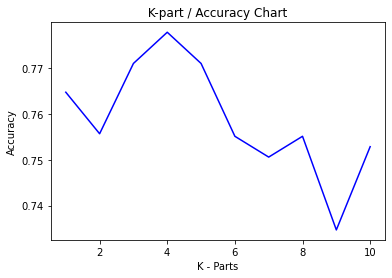

In [22]:
each_accur = visualize(X1,y1,10,original_dataset,rf_n)

plt.plot(range(1,11), each_accur, color = 'blue')
plt.title(" K-part / Accuracy Chart ")
plt.xlabel('K - Parts')
plt.ylabel('Accuracy')
plt.show()

As a result, the best accuracy rate was achieved with Random Forest Classifier. We scaled the data with the Robust Scaler and slightly improved our accuracy. Finally, we achieved our highest accuracy rate of approximately 77.78 percent with RF 10-fold cross validation.

We know that this study, of course, does not replace experienced doctors or decision makers, but we think that it will definitely help people who are related to the subject with an accuracy rate of 78 percent in cases where vital and urgent decisions need to be made. The number of data we had was very small for a project that would be instrumental in making a decision on such an important issue. We worked with 4200 data from approximately real patients. When the number of data is increased over time, the training of the model will be better, so it will give much better results and help to make more final decisions. Apart from the blood test, the project can be developed by supporting with simple urine and stool test results and can give much better results. While examining the dataset, we saw outliers in the attributes with low correlation, as well as outliers. As we said, if the dataset is developed, the project can also be developed and be beneficial to humanity. Thank you for reading us. We wish you healthy days.

## References<a class="anchor" id="references"></a>

https://github.com/scikit-learn/scikit-learn/blob/baf828ca1/sklearn/preprocessing/_data.py#L1344

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

https://www.kaggle.com/datasets/saurabhshahane/patient-treatment-classification

https://www.w3schools.com/python/matplotlib_pie_charts.asp

our homework for the source code.


**Disclaimer!** <font color='grey'>This notebook was prepared by <Emre Mert Dübüş> as a term project for the *BBM469 - Data Intensive Applications Laboratory* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>